# Study showing XGB use for fraud detection

Using XGB models to classify fraudulent transactions in a well-known case study regarding a Tunisian energy company which suffered major financial losses caused by electricity fraud.

Oprea, S.-V., & Bâra, A. (2021). Machine learning classification algorithms and anomaly detection in conventional meters and Tunisian electricity consumption large datasets. Computers &amp; Electrical Engineering, 94, 107329. https://doi.org/10.1016/j.compeleceng.2021.107329

It is important to note that for effective learning, enough data from both classes, fraudulent and non-fraudulent should be provided, even though XGB is better (comparatively) at handling imbalanced data. However, for energy consumption cases such as these, actual fraud cases are typically rare compared to normal cases, leading to severe class imbalance. The imbalance will cause more challenges in learning in the absence of data treatment techniques. As such, over-sampling the minority (fraudulent) class was done to address the imbalance.

___

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, resample
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, precision_score, log_loss, recall_score, roc_curve, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import ADASYN
import joblib

In [2]:
# Loading aggregated dataset
aggregated_invoice = pd.read_csv("aggregated_datasetV3.csv")
aggregated_invoice.columns

Index(['region', 'date', 'dis', 'id', 'catg', 'target', 'id_',
       'consommation_level_1_mean', 'consommation_level_1_max',
       'consommation_level_1_std',
       ...
       'consommation_level_4_2010.0', 'consommation_level_4_2011.0',
       'consommation_level_4_2012.0', 'consommation_level_4_2013.0',
       'consommation_level_4_2014.0', 'consommation_level_4_2015.0',
       'consommation_level_4_2016.0', 'consommation_level_4_2017.0',
       'consommation_level_4_2018.0', 'consommation_level_4_2019.0'],
      dtype='object', length=195)

# Preparing data for XGBoost (Extreme Gradient Boosting)

The dataset has to be split and the imbalanced data has to be handled as the number of fraud cases are underrepresented.

# Splitting the dataset
Using `sklearn`, the data is split into 80% training and 20% testing.

In [3]:
# Separating features & target
X = aggregated_invoice.drop(columns = ["target", "date", "id"])
y = aggregated_invoice["target"]

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# Check distribution of target
print(y_train.value_counts(normalize = True)) # Training set
print(y_test.value_counts(normalize = True)) # Testing set

target
0    0.956133
1    0.043867
Name: proportion, dtype: float64
target
0    0.956152
1    0.043848
Name: proportion, dtype: float64


# Balancing data

Since the dataset is highly imbalanced (as seen by the proportions above), where only a small fraction of it constitutes data for fraud, ADASYN and SMOTE can be used to balance the disparity.

With fraud data constituting a mere ~5% of the entire dataset, ADASYN was chosen to increase the number of fraud datapoints, allowing the model to learn more effectively.

In [4]:
# Generating synthetic data using ADASYN for the minority class
ada = ADASYN(random_state = 42)
X_resampled_ada, y_resampled_ada = ada.fit_resample(X_train, y_train)

# Checking new class distribution
print(pd.Series(y_resampled_ada).value_counts())

target
0    8980
1    8910
Name: count, dtype: int64


# XGBoost model without hyperparameter tuning

Now that the data has been processed, it will be run through the XGBoost model. Below outlines the model architecture, without hyperparameter tuning.

In [ ]:
# Defining the model
xgb_model = XGBClassifier(
    use_label_encoder = False,
    eval_metric = "aucpr",
    scale_pos_weight = 14, # ratio of non-fraud to fraud as base
    objective = "binary:logistic",
    tree_method = "hist", # optimized for spd
    booster = "gbtree"
)

# Fitting the model
xgb_model.fit(X_resampled_ada, y_resampled_ada)

# Obtaining results
result = xgb_model.predict(X_test)

# Model evaluation
print(classification_report(y_test, result))
print(matthews_corrcoef(y_test, result))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:19:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2246
           1       0.16      0.22      0.18       103

    accuracy                           0.91      2349
   macro avg       0.56      0.58      0.57      2349
weighted avg       0.93      0.91      0.92      2349

0.14127881155557334


# XGBoost model with hyperparameter tuning

Below outlines the model architecture, with hyperparameter tuning. (**~1.5hr runtime**)

In [ ]:
# Defining the model
xgb_model = XGBClassifier(
    use_label_encoder = False,
    eval_metric = "aucpr",
    scale_pos_weight = 14, # ratio of non-fraud to fraud as base
    objective = "binary:logistic",
    tree_method = "hist", # optimized for spd
    booster = "gbtree"
)

# Defining the hyperparameter grid
param_grid = {
    "n_estimators": [1000, 1500, 2000],
    "learning_rate": [0.0005, 0.001, 0.01],
    "max_depth": [5, 6, 7],
    "min_child_weight": [3, 5, 10],
    "gamma": [1.0, 2.0, 3.0],
    "subsample": [0.5, 0.7, 0.9],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [50, 100, 200],
    "reg_alpha": [5, 10, 20]
}

# Perform randomised search with stratified 5-fold
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
random_search = RandomizedSearchCV(xgb_model, param_distributions = param_grid, n_iter = 30, scoring = "roc_auc", cv = cv, random_state = 42, verbose = 1, n_jobs = -1)
random_search.fit(X_resampled_ada, y_resampled_ada)

# Output best params
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:22:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'subsample': 0.7, 'reg_lambda': 50, 'reg_alpha': 5, 'n_estimators': 1500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 3.0, 'colsample_bytree': 0.6}


# Evaluation on Test Split

Evaluation of the model is done based on the following metrics:
1. Accuracy
2. Precision
3. Recall
4. Loss
5. Area under curve (AUC)
6. Matthew's Correlation Coefficient (MCC)
7. Confusion Matrix

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:59:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.7790549169859514
Test Precision: 0.09533073929961089
Test Recall: 0.47572815533980584
Test Loss: 7.96366799018808
Test AUC 0.6343467134668753
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2246
           1       0.10      0.48      0.16       103

    accuracy                           0.78      2349
   macro avg       0.53      0.63      0.52      2349
weighted avg       0.93      0.78      0.84      2349

Matthews Correlation Coefficient: 0.13307023900545745



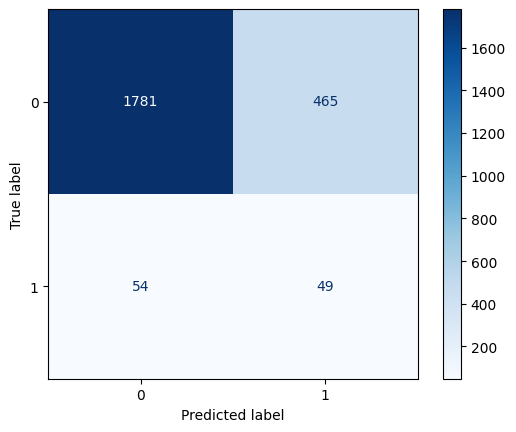

In [ ]:
# Best model
best_xgb = XGBClassifier(
    use_label_encoder = False,
    eval_metric = "aucpr",
    scale_pos_weight = 10,
    objective = "binary:logistic",
    tree_method = "hist",
    booster = "gbtree",
    # **random_search.best_params_ (best params located below)

    subsample = 0.7,
    reg_lambda = 50,
    reg_alpha = 5,
    n_estimators = 1500,
    min_child_weight = 10,
    max_depth = 6,
    learning_rate = 0.01,
    gamma = 3.0,
    colsample_bytree = 0.6
    )

# Fitting the model
best_xgb.fit(X_resampled_ada, y_resampled_ada)

# Testing best model
y_hat_test = best_xgb.predict(X_test)

# Calculating metrics
accuracy = best_xgb.score(X_test, y_test)
precision = precision_score(y_test, y_hat_test)
recall = recall_score(y_test, y_hat_test)
loss = log_loss(y_test, y_hat_test)
auc = roc_auc_score(y_test, y_hat_test)

# Printing metrics
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test Loss:", loss)
print("Test AUC", auc)

print(classification_report(y_test, y_hat_test))
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_hat_test))
print()

# Confusion matrix
cm = confusion_matrix(y_test, y_hat_test)
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_xgb.classes_)
display.plot(cmap = "Blues")

From the above, the XGBoost model performs better than the Logistic Regression model in all metrics besides recall. Reasons explaining the inherently low precision will be covered in the report.

From the confusion matrix, XGBoost predicted many true negatives (much more so than Logistic regression), but struggles to classify true positives.

# Saving the model

Using `joblib`, the trained model with best parameters will be saved.

In [ ]:
# Best model
best_xgb = XGBClassifier(
    use_label_encoder = False,
    eval_metric = "aucpr",
    scale_pos_weight = 10,
    objective = "binary:logistic",
    tree_method = "hist",
    booster = "gbtree",
    # **random_search.best_params_ (best params located below)

    subsample = 0.7,
    reg_lambda = 50,
    reg_alpha = 5,
    n_estimators = 1500,
    min_child_weight = 10,
    max_depth = 6,
    learning_rate = 0.01,
    gamma = 3.0,
    colsample_bytree = 0.6
    )

# Fitting model
best_xgb.fit(X_resampled_ada, y_resampled_ada)

# Saving the model
joblib.dump(best_xgb, 'xgb.joblib')
print("Model saved!")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved!
